# Import libraries

In [39]:
import pandas as pd
import csv
import re
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 
import spacy


from selenium import webdriver 
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from pyvis.network import Network
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#from functions.lotr_functions import *

In [2]:
def download_characters_from_web(page_urls):
     # Create driver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

    # list with character's key, name and url to his website
    characters_list = [] 
    # list with book's key and name 
    books_list=[] 
    # pivot-Table with book key and character key
    book_character_list=[] 
    #book key 
    book_index=0
    # character kex for all books
    character_index=0
    
    
    for page_url in page_urls: 
        #open url 
        driver.get(page_url)

        #click accept cookies if popup shows
        #identify element
        coockies=driver.find_elements(By.XPATH, '//div[text()="ANNEHMEN"]')
        if(len(coockies)>0):
            driver.find_element(By.XPATH, '//div[text()="ANNEHMEN"]').click()  
        #save book name
        book_name=driver.find_element(By.CLASS_NAME, 'page-header__title').text

        #find div with characters 
        table_with_characters=driver.find_element(By.CLASS_NAME, 'appearances')
        #find all characters inside of div with characters 
        character_elements=table_with_characters.find_elements(By.TAG_NAME, 'li')

        #save character
        for character in character_elements:

            character_url=character.find_element(By.TAG_NAME, 'a').get_attribute('href')
            character_name=character.find_element(By.TAG_NAME, 'a').text

            #check if addiitional info exists
            additional_info=character.find_elements(By.TAG_NAME, 'small')
            if(len(additional_info)>0):
                character_add_infos=character.find_element(By.TAG_NAME, 'small').text
                character_add_info = character_add_infos.split(", ")
                character_add_info = character_add_infos.replace(") (", ", ").replace(")", "").replace("(", "")
            else:
                character_add_info=None

            #add character to characters_list and to book_character_list 
            if (next((item for item in characters_list if item["character_name"] ==character_name), None))==None: 
                # Load a page 

                #get other names 
                # Open a new window
                driver.execute_script("window.open('');")

                # Switch to the new window and open new URL
                driver.switch_to.window(driver.window_handles[1])
                driver.get(character_url)
                try:
                    other_names_section=driver.find_element(By.XPATH, '//div[@data-source="othernames"]')
                    other_names_str=other_names_section.find_element(By.CLASS_NAME, 'pi-data-value').text
                    other_names_str = re.sub('\[\d\]', '', other_names_str)
                    other_names_str=other_names_str.replace(",\n","; ")
                    other_names_str=other_names_str.replace("\n","; ")
                    other_names_str=other_names_str.replace(", ","; ")
                    other_names=other_names_str.split("; ")
                except NoSuchElementException:
                    other_names=[]
                # Closing new_url tab
                driver.close()

                # Switching to old tab
                driver.switch_to.window(driver.window_handles[0])        
         
                characters_list.append({"character_key": character_index, "character_name": character_name, "character_firstname":character_name.split(' ', 1)[0], "other_names": other_names, "character_url": character_url})
                book_character_list.append({"book_key": book_index, "character_key": character_index, "add_info": character_add_info})
                character_index=character_index+1
            else: 
                book_character_list.append({"book_key": book_index, "character_key": next(item for item in characters_list if item["character_name"] ==character_name)["character_key"], "add_info": character_add_info})

        books_list.append({"key": book_index, "name": book_name})
        book_index=book_index+1
    driver.close()
    characters_list_df=pd.DataFrame(characters_list)
    return characters_list_df

In [11]:
def compare_two_sources(characters_list_df, page_url):
    #get all characters from book
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(page_url)

    #list with characters from second source 
    book_characters=[]

    book_characters_unique=[]

    #find div with characters 
    book_table_with_characters=driver.find_element(By.CLASS_NAME, 'mw-category')

    #find all characters inside of div with characters 
    book_character_elements=book_table_with_characters.find_elements(By.TAG_NAME, 'a')

    [book_characters.append({"character_name": character.text, "character_url": character.get_attribute('href')}) for character in book_character_elements]

    last_index_of_df=characters_list_df['character_key'].tail(1).index[0]
    for i, item in enumerate(book_characters):
        if item["character_name"] not in list(characters_list_df.character_name) and item["character_name"].split(' ', 1)[0] not in list(characters_list_df.character_firstname):
            last_index_of_df=last_index_of_df+1
            characters_list_df.loc[len(characters_list_df.index)] = [last_index_of_df, item["character_name"], item["character_name"].split(' ', 1)[0], [], item["character_url"]]
            book_characters_unique.append(item)
    driver.close()    
    return characters_list_df

In [4]:
import spacy
def get_book_text(book_name):

    # Load spacy English languague model
    NER=spacy.load("en_core_web_sm")
    book_text = open(book_name).read()
    book_doc = NER(book_text)
    
    return book_doc


In [5]:
def get_entity_list_per_sentence(book_doc):
    sent_entity_df=[]
    # Loop through sentences, store named entity list for each sentence
    for sent in book_doc.sents: 
        entity_list=[ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})
    sent_entity_df=pd.DataFrame(sent_entity_df) 
    
    return sent_entity_df

In [6]:
import os
def filter_entity(ent_list, character_df): 
    ent_list_finale=[]
    for ent in ent_list:
        if ent in list(character_df.character_name):
            index=list(character_df.character_name).index(ent)
            ent_list_finale.append(character_df.character_name[index])
        elif ent in list(character_df.character_firstname):
            index=list(character_df.character_firstname).index(ent)
            ent_list_finale.append(character_df.character_name[index])
        else: 
            for num, other_names in enumerate(list(character_df.other_names)):
                if ent in other_names: 
                    ent_list_finale.append(character_df.character_name[num])
    return ent_list_finale

           

In [7]:
def create_relationships (df, window_size): 
    
    relationships = []

    for i in range(df.index[-1]):
        end_i = min(i + window_size, df.index[-1])
        char_list = sum((df.loc[i: end_i].character_entities), [])
        
        # Remove duplicated characters that are next to each other
        char_unique = [char_list[i] for i in range(len(char_list)) 
                       if (i==0) or char_list[i] != char_list[i-1]]

        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})
           
    relationship_df = pd.DataFrame(relationships)
   
    # Sort the cases with a->b and b->a
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), 
                                   columns = relationship_df.columns)
    relationship_df["value"] = 1
    relationship_df = relationship_df.groupby(["source","target"], 
                                              sort=False, 
                                              as_index=False).sum()
                
    return relationship_df

# Load characters

In [12]:
# Create driver
#driver = webdriver.Chrome(ChromeDriverManager().install())
#driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

page_urls = ["https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring", "https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Two_Towers", "https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Return_of_the_King"]
characters_list_df = download_characters_from_web(page_urls)
characters_list_df = compare_two_sources(characters_list_df, "https://tolkiengateway.net/wiki/Category:Characters_in_The_Lord_of_the_Rings")
#save_characters_to_csv(characters_list, 'characters')

# Load books

In [14]:
# get all book files in the data directionary
all_books= [b for b in os.scandir('data/books') if '.txt' in b.name]

In [12]:
from spacy import displacy

book=all_books[1]
NER=spacy.load("en_core_web_sm")
book_text = open(book).read()
book_doc = NER(book_text)

ruler=NER.add_pipe("entity_ruler")

#pattern={"pattern": [{"TEXT": {"FUZZY": {"IN": characters_list_df["character_firstname"].tolist() }}}], "label": "POSITIVE"}
#pattern={"pattern": [{"TEXT": {"FUZZY": {"IN": ["Aragorn"] }}}], "label": "POSITIVE"}
patterns ==[{"label": "GADGET", "pattern": "Aragorn"}]


ruler.add_patterns([{"label": "flower", "pattern": "Aragorn"}])
doc=NER("Aragorn is cool")
displacy.render(book_doc, style="ent", jupyter=True)

NameError: name 'patterns' is not defined

In [15]:
#loop through book list
sent_entity_df_all=pd.DataFrame(columns=['sentence','entities','character_entities', 'book_id'])
relationships_df_all=pd.DataFrame(columns=['source','target','value', 'book_id'])

relationships_df_throughout_all_books=pd.DataFrame(columns=['source','target','value'])

#pattern_first_name_characters=[]
#for character in characters_list_df: 
#    pattern=characters_list_df["character_first_name"] 
#   matcher.add("test_p", [pattern])

#add characters from list to spacy vocabulary 

for num, book in enumerate(all_books):
    book_doc=get_book_text(book)

    #get entity list per sentence
    sent_entity_df=get_entity_list_per_sentence(book_doc)
   
    #select sentences only with characters' names
    sent_entity_df['character_entities']=sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_list_df))

    # filter out sentences that don't have any character enitites
    sent_entity_df_filtered= sent_entity_df[sent_entity_df['character_entities'].map(len)>0]
    
    #create relationships for current book
    relationships_df=create_relationships(df=sent_entity_df_filtered, window_size=8)
    
    #save book_number for entities and relationships
    sent_entity_df_filtered['book_id'] = num
    sent_entity_df_all=pd.concat([sent_entity_df_all,sent_entity_df_filtered])
    
    relationships_df['book_id'] = num
    relationships_df_all=pd.concat([relationships_df_all, relationships_df])
    



C:\Users\Arina Lavrova\AppData\Local\Temp\ipykernel_6868\472075028.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['book_id'] = num
C:\Users\Arina Lavrova\AppData\Local\Temp\ipykernel_6868\472075028.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['book_id'] = num
C:\Users\Arina Lavrova\AppData\Local\Temp\ipykernel_6868\472075028.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [16]:
#relationships throughout all books
relationships_df_throughout_all_books=relationships_df_all.groupby(["source","target"], 
                                              sort=False, 
                                              as_index=False)['value'].sum()

In [17]:
relationships_df_throughout_all_books.sort_values(by='value', ascending=False).head(150)

,source,target,value
43,Frodo Baggins,Samwise Gamgee,4665
37,Meriadoc Brandybuck,Peregrin Took,1418
228,Gimli,Legolas,1274
0,Bilbo Baggins,Frodo Baggins,1174
54,Gollum,Samwise Gamgee,1085
...,...,...,...
156,Elrond,Gimli,42
222,Gandalf,Gwaihir,40
144,Arwen,Elrond,40
308,Celeborn,Treebeard,40


# Create Relationships

# Graph visualisation

In [18]:
#characters_list_df, books_list_df, book_character_list

book_character_list_df_new=pd.DataFrame(book_character_list.groupby('character_name').book_name.apply(list).reset_index())
#book_character_list_df['character_key']=df['Group'].map(df1.set_index('Group')['Hotel'])
book_character_list_df_new

NameError: name 'book_character_list' is not defined

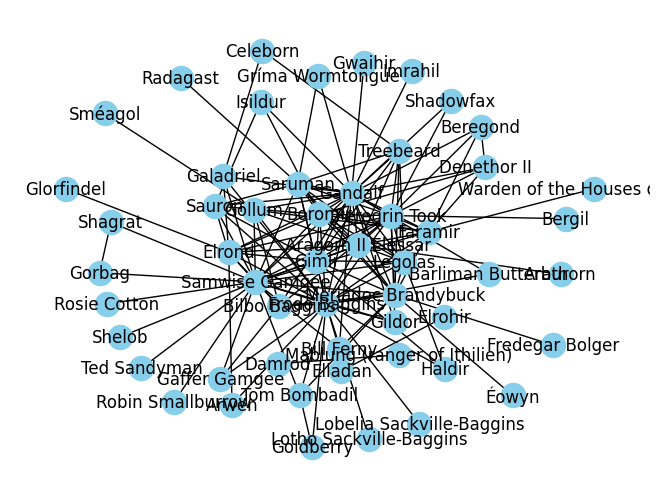

In [19]:
# Create a graph from a pandas dataframe
import networkx as nx 

G =nx.from_pandas_edgelist(relationships_df_throughout_all_books.sort_values(by='value', ascending=False).head(150),
                          source="source",
                          target="target", 
                          edge_attr="value",
                          create_using=nx.Graph())
#add book names 
#nodes_attr_book = book_character_list_df.set_index('character_name').to_dict(orient = 'index')
#nx.set_node_attributes(G, nodes_attr_book)
#node_colors = {'The Lord of the Rings: The Two Towers': 'blue', 'The Lord of the Rings: The Fellowship of the Ring': 'red'}

pos= nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

## Graph visualization Python - Pyvis

In [20]:
net= Network(notebook = True, 
             width="1300px", 
             height="700px", 
             bgcolor="#000000", 
             font_color="#ffffff"
             #select_menu=True,
             #cdn_resources='remote'
             #filter_menu=True
            )

node_degree=dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("lord_of_rings.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [21]:
import community as community_louvain

communities= community_louvain.best_partition(G)

nx.set_node_attributes(G, communities, 'group')
com_net= Network(notebook = True, width="1300px", height="700px", bgcolor="#000000", font_color="#ffffff",select_menu=True, cdn_resources='remote')
com_net.from_nx(G)
com_net.show("lord_of_rings_comminities.html")

# Characters' omportance over time

In [22]:
relationships_df_all.sort_values(['book_id', 'value'], ascending=[True, False]).groupby('book_id').head(10)

books_graph=[]
books_graph_weighted=[]

degree_centrality_nodes_all_books=pd.DataFrame(columns=['node','degree_centrality'])


for num, book in enumerate(all_books):
    G =nx.from_pandas_edgelist(relationships_df_all.loc[relationships_df_all['book_id'] == num],
                          source="source",
                          target="target", 
                          edge_attr="value",
                          create_using=nx.Graph())
    
    #Sort for identifying most inflential nodes using degree centrality
    degree_centrality_nodes=[]
    degree_centrality = nx.degree_centrality(G)
    
    for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True):
        degree_centrality_nodes.append({"node": node, "degree_centrality": degree_centrality[node]})   
        
    #get 5 the most important characters 
    degree_centrality_nodes_df = pd.DataFrame(degree_centrality_nodes).sort_values(by='degree_centrality', ascending=False)
    degree_centrality_nodes_all_books=pd.concat([degree_centrality_nodes_all_books, degree_centrality_nodes_df])
    books_graph.append(G)

In [23]:
degree_centrality_nodes_all_books=degree_centrality_nodes_all_books.sort_values(by='degree_centrality', ascending=False)
degree_centrality_nodes_all_books=degree_centrality_nodes_all_books.drop_duplicates(subset='node', keep="first") #.sort_values(by='degree_centrality', ascending=False).groupby('node')
degree_centrality_nodes_all_books=degree_centrality_nodes_all_books.reset_index(drop=True).loc[0:7]

most_important_characters=degree_centrality_nodes_all_books["node"].tolist() 
degree_centrality_nodes_all_books

,node,degree_centrality
0,Frodo Baggins,0.871795
1,Samwise Gamgee,0.724138
2,Elrond,0.666667
3,Gandalf,0.666667
4,Aragorn II Elessar,0.595238
5,Boromir,0.571429
6,Peregrin Took,0.512821
7,Bilbo Baggins,0.512821


<AxesSubplot: >

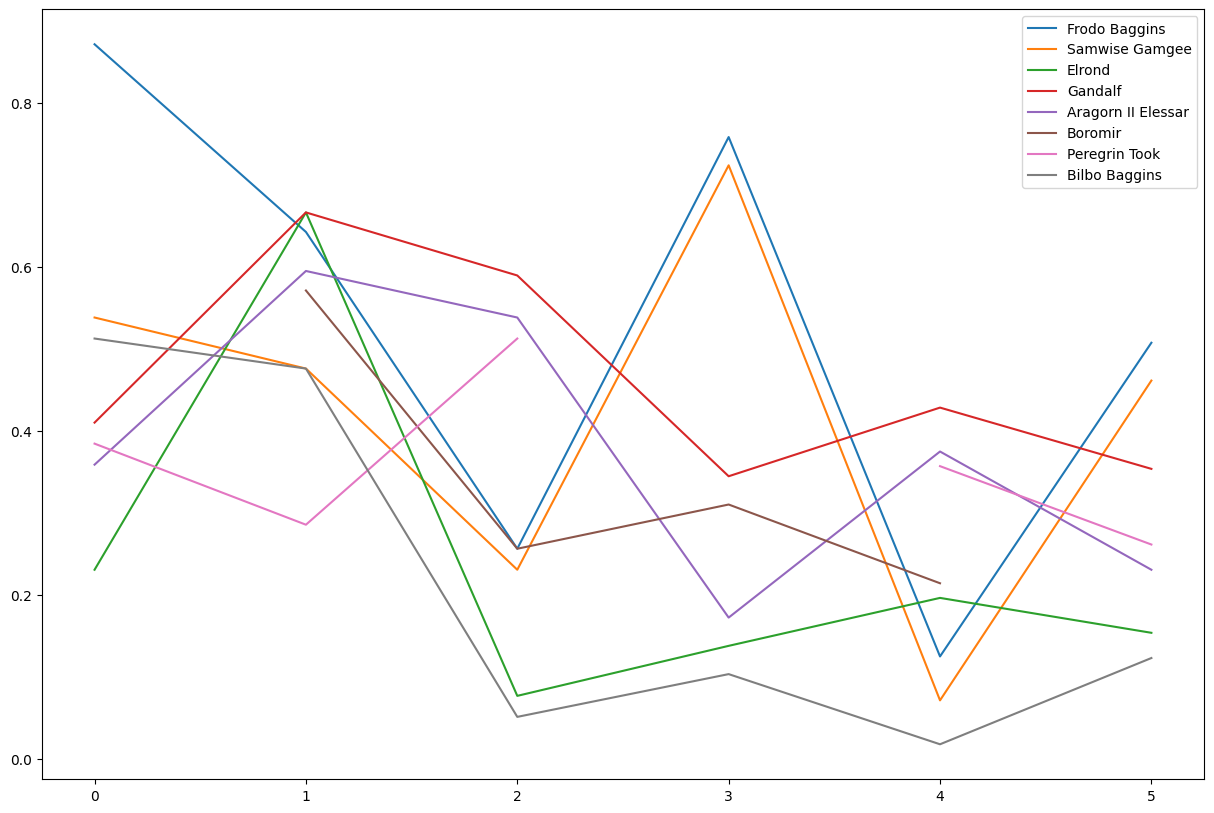

In [24]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters

degree_evol_df[most_important_characters].plot(figsize=(15,10))

# Wordclouds

In [52]:
book_text = open(all_books[0]).read()
en = spacy.load('en_core_web_sm')

stopwords_spacy=en.Defaults.stop_words
stopwords = stopwords_spacy.union(STOPWORDS)
stopwords.update(["said"])


for num, book in enumerate(all_books):
    book_text = open(book).read()
    
    #custom_mask = np.array(Image.open("wordclouds/siluets/"+str(num)+".png"))
    
    wc=WordCloud(
        background_color='white', 
        max_words=400,
        stopwords=stopwords, 
       # mask=custom_mask,
        height=600,
        width=400
    )

    wc.generate(book_text)

    wc.to_file('wordclouds/wc_book_'+str(num)+'.png')

# Test own entities

In [87]:
characters_pattern_list=[]

characters_pattern_list=characters_pattern_list + characters_list_df["character_firstname"].tolist()
characters_pattern_list=characters_pattern_list + characters_list_df["character_name"].tolist()
for num, other_names in enumerate(list(characters_list_df["other_names"])):
    characters_pattern_list=characters_pattern_list + other_names
characters_pattern_list

['Albert',
 'Aragorn',
 'Arathorn',
 'Arwen',
 'Balin',
 'Barliman',
 'Belladonna',
 'Bilbo',
 'Boromir',
 'Bungo',
 'Celeborn',
 'Círdan',
 'Déagol',
 'Denethor',
 "Durin's",
 'Eärendil',
 'Ecthelion',
 'Elendil',
 'Elrond',
 'Everard',
 'Farmer',
 'Frodo',
 'Fundin',
 'Galadriel',
 'Gandalf',
 'Gil-galad',
 'Gilraen',
 'Gimli',
 'Glóin',
 'Gollum',
 'Gwaihir',
 'Haldir',
 'Hamfast',
 'Isildur',
 'Khamûl',
 'Legolas',
 'Lobelia',
 'Lurtz',
 'Meriadoc',
 'Morgoth',
 'Mrs.',
 'Old',
 'Otho',
 'Peregrin',
 'Rosie',
 'Samwise',
 'Saruman',
 'Sauron',
 'Smaug',
 'Ted',
 'Thorin',
 'Thranduil',
 'Tom,',
 'Witch-king',
 'Aldor',
 'Barahir',
 'Éomer',
 'Éomund',
 'Éothain',
 'Éowyn',
 'Faramir',
 'Freda',
 'Gamling',
 'Gárulf',
 'Gríma',
 'Grishnákh',
 'Haleth',
 'Háma',
 'Helm',
 'Madril',
 'Mauhúr',
 'Morwen',
 'Shadowfax',
 'Sharku',
 'Shelob',
 'Snaga',
 'Thengel',
 'Théoden',
 'Théodred',
 'Théodwyn',
 'Treebeard',
 'Uglúk',
 'Alatar',
 'Anárion',
 'Damrod',
 'Ecthelion',
 'Elanor',
 'El

In [100]:
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")


# Load spacy English languague model
NER=spacy.load("en_core_web_sm")

phrase_matcher = PhraseMatcher(NER.vocab)

#characters = [NER.make_doc(text) for text in characters_pattern_list]

patterns = [NER(character) for character in characters_pattern_list]  # process each word to create phrase pattern

phrase_matcher.add('LOTR_CHARACTERS', None, *patterns)  # add patterns to matcher

book_text = open(all_books[5]).read()
book_doc = NER(book_text)
matches = phrase_matcher(book_doc)

Sam


ValueError: [E1010] Unable to set entity information for token 11 which is included in more than one span in entities, blocked, missing or outside.

In [93]:
matches

[(10582656020180343756, 11, 12),
 (10582656020180343756, 299, 300),
 (10582656020180343756, 416, 417),
 (10582656020180343756, 448, 449),
 (10582656020180343756, 458, 459),
 (10582656020180343756, 477, 478),
 (10582656020180343756, 486, 487),
 (10582656020180343756, 503, 504),
 (10582656020180343756, 505, 506),
 (10582656020180343756, 528, 529),
 (10582656020180343756, 529, 530),
 (10582656020180343756, 589, 590),
 (10582656020180343756, 615, 616),
 (10582656020180343756, 691, 692),
 (10582656020180343756, 844, 845),
 (10582656020180343756, 852, 853),
 (10582656020180343756, 878, 879),
 (10582656020180343756, 1016, 1017),
 (10582656020180343756, 1065, 1066),
 (10582656020180343756, 1175, 1176),
 (10582656020180343756, 1212, 1213),
 (10582656020180343756, 1260, 1261),
 (10582656020180343756, 1262, 1263),
 (10582656020180343756, 1296, 1297),
 (10582656020180343756, 1317, 1318),
 (10582656020180343756, 1344, 1345),
 (10582656020180343756, 1552, 1553),
 (10582656020180343756, 1639, 1640),


In [180]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

animals = ['cat', 'Bilbo']

nlp = spacy.load('en_core_web_sm')  # or any other model
patterns = [nlp(animal) for animal in animals]  # process each word to create phrase pattern
matcher = PhraseMatcher(nlp.vocab)
matcher.add('PERSON', None, *patterns)  # add patterns to matcher

doc = nlp("I have a cat cat a dog and fish az and Bilbo afafa Aragorn. And test Germany Awen")
matcher = matcher(doc)


sent_entity_df=[]
 # Loop through sentences, store named entity list for each sentence
for sent in doc.sents: 
    entity_list=[]
    for match_id, start, end in matches:
        # create a new Span for each match and use the match_id (ANIMAL) as the label
        span = Span(doc, start, end, label=match_id)
        print('span')
        print(span)
        entity_list.append(span)
        sent_entity_df.append({"sentence": sent, "entities": entity_list})
sent_entity_df=pd.DataFrame(sent_entity_df) 


for match_id, start, end in matches:
    # create a new Span for each match and use the match_id (ANIMAL) as the label
    span = Span(doc, start, end, label=match_id)
    print(span)
    print(match_id)
    
    if(span in list(doc.ents)): #and    list(doc.ents).index("ent")    ent.label_!=NULL):
        print("no label")
    else:
        doc.ents = list(doc.ents) + [span]  # add span to doc.ents

print([(ent.text, ent.label_) for ent in doc.ents])  # [('cat', 'ANIMAL')]

span
cat
span
Bilbo
span
cat
span
Bilbo
cat
380
Bilbo
380
no label
[('cat', 'PERSON'), ('Bilbo', 'PERSON'), ('Aragorn', 'GPE'), ('Germany', 'GPE')]


In [179]:
type(doc)

spacy.tokens.doc.Doc

In [127]:
#Import the requisite library
import spacy

#Sample text
text = "This is a sample number (555) 555-5555 Bilbo."

#Build upon the spaCy Small Model
nlp = spacy.blank("en")

#Create the Ruler and Add it
ruler = nlp.add_pipe("entity_ruler")

#List of Entities and Patterns (source: https://spacy.io/usage/rule-based-matching)
patterns = [
                {"label": "PHONE_NUMBER", "pattern": [{"ORTH": "("}, {"SHAPE": "ddd"}, {"ORTH": ")"}, {"SHAPE": "ddd"},
                {"ORTH": "-", "OP": "?"}, {"SHAPE": "dddd"}]}
            ]
#add patterns to ruler
ruler.add_patterns(patterns)



#create the doc
doc = nlp(text)

#extract entities
for ent in doc.ents:
    print (ent.text, ent.label_)

(555) 555-5555 PHONE_NUMBER


In [136]:
for tok in doc:
        print("tok")
        print(tok)
        print("ent_type_")
        print(tok.ent_type_)
        print("ent_iob_")
        print( tok.ent_iob_)

tok
I
ent_type_

ent_iob_
O
tok
have
ent_type_

ent_iob_
O
tok
a
ent_type_

ent_iob_
O
tok
cat
ent_type_
PERSON
ent_iob_
B
tok
and
ent_type_

ent_iob_
O
tok
a
ent_type_

ent_iob_
O
tok
dog
ent_type_

ent_iob_
O
tok
and
ent_type_

ent_iob_
O
tok
fish
ent_type_

ent_iob_
O
tok
az
ent_type_

ent_iob_
O
tok
and
ent_type_

ent_iob_
O
tok
Bilbo
ent_type_
PERSON
ent_iob_
B
